<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/sequential_testing_for_count_and_countinuous_data_using_ASOS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [204]:
# Specifying the directories and paths
working_folder = Path(".")


data_folder = Path.joinpath(working_folder,"data")
data_folder.mkdir(parents=True, exist_ok=True)

abtest_metrics_local_path = Path.joinpath(data_folder,"asos_digital_experiments_dataset.parquet")
abtest_metrics_remote_path = "https://osf.io/62t7f/download"

# Download the dataset if it does not already exist
# The body of the if-statement is a shell command
if not abtest_metrics_local_path.exists():
    !wget -O $abtest_metrics_local_path $abtest_metrics_remote_path

# Load the dataset
abtest_metrics_df = pd.read_parquet(abtest_metrics_local_path)



In [205]:
abtest_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24153 entries, 0 to 24152
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   experiment_id     24153 non-null  object 
 1   variant_id        24153 non-null  int64  
 2   metric_id         24153 non-null  int64  
 3   time_since_start  24153 non-null  float64
 4   count_c           24153 non-null  float64
 5   count_t           24153 non-null  float64
 6   mean_c            24153 non-null  float64
 7   mean_t            24153 non-null  float64
 8   variance_c        23375 non-null  float64
 9   variance_t        23374 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 1.8+ MB


In [206]:
abtest_metrics_df["experiment_id"]=abtest_metrics_df["experiment_id"].astype(str)
abtest_metrics_df["variant_id"]=abtest_metrics_df["variant_id"].astype("category")
abtest_metrics_df["metric_id"]=abtest_metrics_df["metric_id"].astype("category")
abtest_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24153 entries, 0 to 24152
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   experiment_id     24153 non-null  object  
 1   variant_id        24153 non-null  category
 2   metric_id         24153 non-null  category
 3   time_since_start  24153 non-null  float64 
 4   count_c           24153 non-null  float64 
 5   count_t           24153 non-null  float64 
 6   mean_c            24153 non-null  float64 
 7   mean_t            24153 non-null  float64 
 8   variance_c        23375 non-null  float64 
 9   variance_t        23374 non-null  float64 
dtypes: category(2), float64(7), object(1)
memory usage: 1.5+ MB


In [207]:
# Definition of metrics

# 1: binary
# 2: count
# 3: count
# 4: Non negative real numbers
## b - binary/count metrics
## r - continuous real numbers
data_dict = {1: "b", 2: "b", 3: "b", 4: "r"}

In [208]:
# Filter by
## experiment_id
## variant_id
## metric_id
# Return all columns

exp_id="db7752"
var_id=1
met_id=2

abtest_metrics_df_filtered=abtest_metrics_df.loc[(abtest_metrics_df['experiment_id']==exp_id) &\
                                                 (abtest_metrics_df['variant_id']==var_id) &\
                                                 (abtest_metrics_df['metric_id']==met_id)]

abtest_metrics_df_filtered

,experiment_id,variant_id,metric_id,time_since_start,count_c,count_t,mean_c,mean_t,variance_c,variance_t
20081,db7752,1,2,8.0,1933300.0,1927621.0,0.170365,0.170382,0.266791,0.268516
20082,db7752,1,2,8.5,1985317.0,1979424.0,0.174195,0.174689,0.275843,0.281334
20083,db7752,1,2,9.0,2063126.0,2057479.0,0.184166,0.184011,0.302500,0.303049
20084,db7752,1,2,9.5,2112970.0,2106821.0,0.187972,0.187991,0.311581,0.312479
20085,db7752,1,2,10.0,2190902.0,2184620.0,0.196252,0.196353,0.331781,0.333406
...,...,...,...,...,...,...,...,...,...,...
20144,db7752,1,2,40.0,4371390.0,4365134.0,0.410827,0.410948,1.248128,1.244968
20145,db7752,1,2,40.5,4388908.0,4382719.0,0.411786,0.412142,1.254558,1.257382
20146,db7752,1,2,41.0,4417511.0,4411400.0,0.414342,0.414377,1.275319,1.270918
20147,db7752,1,2,41.5,4437598.0,4431268.0,0.415183,0.415271,1.280894,1.276542


In [209]:
def bin_assignment_probability_calc(sample_c,sample_mu):
  count=sample_c*sample_mu
  ones_assignment_prb=count/sample_c
  return ones_assignment_prb


In [210]:
from scipy.special import loggamma, gammaln, xlogy
import numpy as np

def sequential_p_value(counts, assignment_probabilities, dirichlet_alpha=None):
    """
    Compute the sequential p-value for given counts and assignment probabilities.
    Lindon, Michael, and Alan Malek.
    "Anytime-Valid Inference For Multinomial Count Data."
    In Advances in Neural Information Processing Systems, 2022
    https://openreview.net/pdf?id=a4zg0jiuVi
    Parameters
    ----------
    counts : array like
        The observed counts in each treatment group.
    assignment_probabilities : array like
        The assignment probabilities to each treatment group.
    dirichlet_alpha : array like, optional
        The Dirichlet mixture parameter.
    Returns
    -------
    float
        The sequential p-value.
    """
    counts = np.array(counts)
    assignment_probabilities = np.array(assignment_probabilities)
    if dirichlet_alpha is None:
        dirichlet_alpha = 100 * assignment_probabilities
    else:
        dirichlet_alpha = np.array(dirichlet_alpha)
    lm1 = (
        loggamma(counts.sum() + 1)
        - loggamma(counts + 1).sum()
        + loggamma(dirichlet_alpha.sum())
        - loggamma(dirichlet_alpha).sum()
        + loggamma(dirichlet_alpha + counts).sum()
        - loggamma((dirichlet_alpha + counts).sum())
    )
    lm0 = gammaln(counts.sum() + 1) + np.sum(
        xlogy(counts, assignment_probabilities) - gammaln(counts + 1), axis=-1
    )
    return min(1, np.exp(lm0 - lm1))

In [211]:
ctrl_c=188065
ctrl_mu=0.3478316360445638
ctrl_prb=bin_assignment_probability_calc(ctrl_c,ctrl_mu)
ctrl_prb

0.3478316360445638

In [212]:
trt_c=186686
trt_mu=0.34740310181340905
trt_prb=bin_assignment_probability_calc(trt_c,trt_mu)
trt_prb

0.34740310181340905

In [213]:
counts = [ctrl_c, trt_c]
assignment_probabilities = [ctrl_prb, trt_prb]
sequential_p_value(counts, assignment_probabilities)

0.0

In [214]:
def bin_sequential_p_value(ctrl_c,ctrl_mu,trt_c,trt_mu):
  ctrl_prb=bin_assignment_probability_calc(ctrl_c,ctrl_mu)
  trt_prb=bin_assignment_probability_calc(trt_c,trt_mu)
  counts = [ctrl_c, trt_c]
  assignment_probabilities = [ctrl_prb, trt_prb]
  return sequential_p_value(counts, assignment_probabilities,dirichlet_alpha=50)


In [215]:
abtest_metrics_df_filtered['sequential_p_value']=abtest_metrics_df_filtered.apply(lambda x: bin_sequential_p_value(x['count_c'],x['mean_c'],x['count_t'],x['mean_t']),axis=1)

<ipython-input-215-871659a97e4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abtest_metrics_df_filtered['sequential_p_value']=abtest_metrics_df_filtered.apply(lambda x: bin_sequential_p_value(x['count_c'],x['mean_c'],x['count_t'],x['mean_t']),axis=1)


In [216]:
abtest_metrics_df_filtered[["time_since_start","count_c","count_t","sequential_p_value"]]

,time_since_start,count_c,count_t,sequential_p_value
20081,8.0,1933300.0,1927621.0,0.0
20082,8.5,1985317.0,1979424.0,0.0
20083,9.0,2063126.0,2057479.0,0.0
20084,9.5,2112970.0,2106821.0,0.0
20085,10.0,2190902.0,2184620.0,0.0
...,...,...,...,...
20144,40.0,4371390.0,4365134.0,0.0
20145,40.5,4388908.0,4382719.0,0.0
20146,41.0,4417511.0,4411400.0,0.0
20147,41.5,4437598.0,4431268.0,0.0


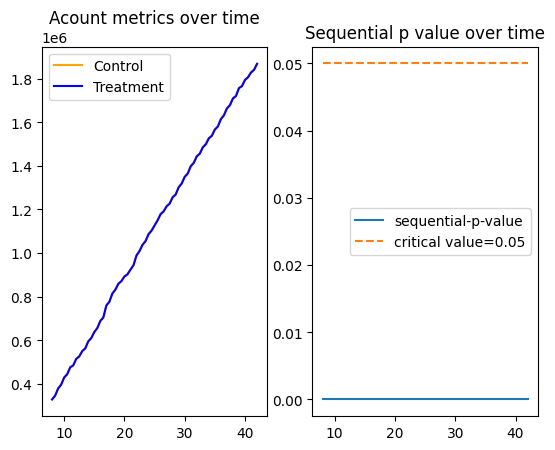

In [217]:
plt.subplot(1,2,1)
plt.title("Acount metrics over time")
plt.plot(abtest_metrics_df_filtered["time_since_start"],\
             abtest_metrics_df_filtered["count_c"]*abtest_metrics_df_filtered["mean_c"],\
         color="orange",label="Control")
plt.plot(abtest_metrics_df_filtered["time_since_start"],\
             abtest_metrics_df_filtered["count_t"]*abtest_metrics_df_filtered["mean_t"],\
         color="blue",label="Treatment")
plt.xlabel="Time since start"
plt.ylabel="Counts"
plt.legend()



plt.subplot(1,2,2)
plt.title("Sequential p value over time")
plt.plot(abtest_metrics_df_filtered["time_since_start"],abtest_metrics_df_filtered["sequential_p_value"],\
         label="sequential-p-value")
plt.plot(abtest_metrics_df_filtered["time_since_start"],[0.05]*len(abtest_metrics_df_filtered["time_since_start"]),\
         '--',label="critical value=0.05")
plt.xlabel="Time since start"
plt.ylabel="p-value"
plt.legend()

plt.show()


